In [1]:
import csv, math
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
from os.path import expanduser

In [2]:
def simplify_points(points, r):
    """Return a maximal list of elements of points such that no pairs of
    points in the result have distance less than r.
    """
    result = []
    for p in points:
        if all(dist(p, q) >= r for q in result):
            result.append(p)
    return result

def order_pts(pts, starter):
    """no pairs of points in the result have distance less than r.
    """
    r = 0.1#0.08
    # print(pts)
    #new_pts = simplify_points(pts, r)
    # print(new_pts)
    new_pts = pts
    ordered_pts = []
    ind = starter #try zero if not working
    for i in range(len(new_pts)-1):
        p = new_pts.pop(ind)
        ctree = cKDTree(new_pts)
        dis, ind =  ctree.query(p, k=1)
        if dis < 10*r:
          ordered_pts.append(p)
    #ordered_pts.append(new_pts[-1])
    ordered_pts.append(ordered_pts[0])
    ordered_pts = np.array(ordered_pts)
    ox = ordered_pts[:,0].flatten()
    oy = ordered_pts[:,1].flatten()
    #smx, smy = smoothener(ordered_pts)
    return ox, oy #, smx, smy


In [56]:
def tf_points(x, y):
    #look out for the role of reolution here 0.5 or 0.05 thingy
    rmx = (x*0.05 - 11.7)*-1
    rmy = (y*0.05 - 13.7)
    return rmx, rmy

In [52]:
def map_inflate(f):
    size = 6
    with open(f, 'rb') as pgmf:
        im = plt.imread(pgmf)
    data = np.array(im)
    # data = np.pad(dat, size, pad_with)
    w, h = np.shape(data)
    data = data.flatten().tolist()
    new_data = []
    for i in data:
        if i == 0: k = 100
        elif i > 206: k = 0
        else: k = -1
        new_data.append(k)
    map_ = np.reshape(np.array(new_data), (w, h))
    xs = []
    ys = []
    for x in range(w):
        for y in range(h):
            if (map_[x][y] > 0):
                rmx, rmy = tf_points(x, y)
                #print(x, y, rmx, rmy)
                xs.append(rmx)
                ys.append(rmy)
                #map2[x-k:x+k,y-k:y+k]= b
    return xs, ys

In [53]:
def dist(p, q):
    "Return the Euclidean distance between points p and q."
    return math.hypot(p[0] - q[0], p[1] - q[1])


In [63]:
def file_reader(file):
  with open (file , 'r') as p:
      point_data = list(csv.reader(p))
      p.close()

  traj_ = []
  xs = []
  ys = []
  for i in range(len(point_data)):
      traj_.append((float(point_data[i][0]), float(point_data[i][1])))
      xs.append(float(point_data[i][0]))
      ys.append(float(point_data[i][1]))
  traj_.append(traj_[0])
  xs.append(xs[0])
  ys.append(ys[0])
  return xs, ys, traj_


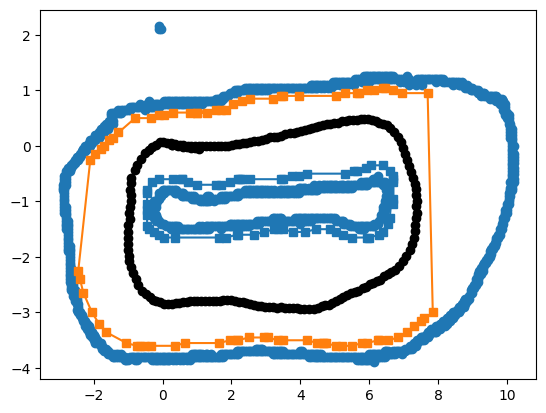

In [64]:
home = expanduser('~')
fileleft = home + "/f1ten-scripts/csv/leftwp.csv"
filemid = home + "/f1ten-scripts/csv/refwp.csv"
fileright = home + "/f1ten-scripts/csv/rightwp.csv"
mapfile = home + "/f1ten-scripts/map.pgm"
ox, oy = map_inflate(mapfile) #inflated map
rx_, ry_, rts = file_reader(fileright) #right border
#rx, ry = order_pts(rts, -1)
rx, ry = rx_, ry_
lx_, ly_, lts = file_reader(fileleft) # left border
lx, ly = lx_, ly_
#lx, ly = order_pts(lts, -1)
xs, ys, pts = file_reader(filemid) #old traj
plt.plot(xs, ys, marker="o", color="black")
plt.plot(rx_, ry_, marker="s")
plt.plot(lx_, ly_, marker="s")
plt.scatter(oy, ox)
for i in range(len(ox)):
    plt.gcf().gca().add_artist(plt.Circle((oy[i], ox[i]), 0.05))


before pairing


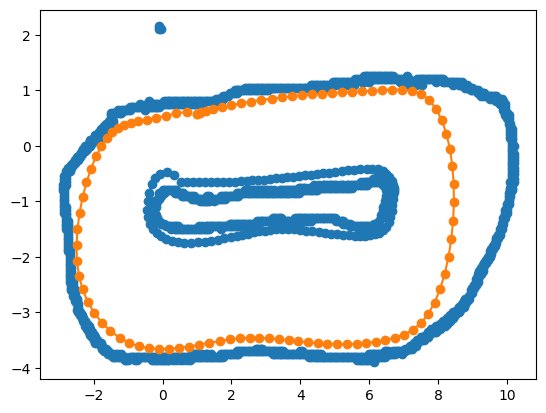

In [65]:
from scipy.interpolate import splprep, splev, splder
tr, ur = splprep([rx, ry], s=0.5)
unew = np.arange(0, 1.00, 0.01)
new_points_right = splev(unew, tr)
plt.plot(new_points_right[0], new_points_right[1], marker='o')

tl, ul = splprep([lx, ly], s=0.5)
unew2 = np.arange(0, 1.00, 0.01)
new_points_left = splev(unew2, tl)
plt.plot(new_points_left[0], new_points_left[1], marker='o')
# for i in range(len(ox)):
#   plt.gcf().gca().add_artist(plt.Circle((oy[i], ox[i]), 0.05))
print("before pairing")
plt.scatter(oy, ox)
for i in range(len(ox)):
    plt.gcf().gca().add_artist(plt.Circle((oy[i], ox[i]), 0.05))


(100,)


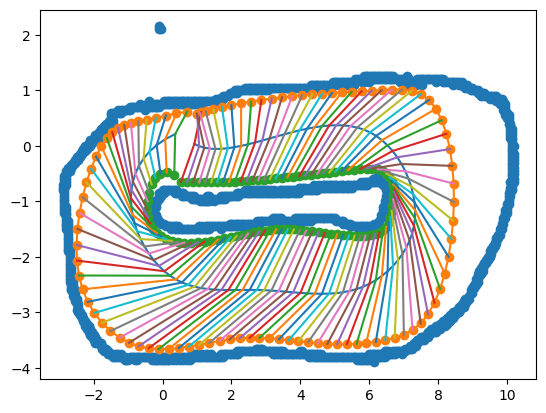

In [66]:
##try midspline
x3 = (new_points_right[0] + new_points_left[0])*0.5
y3 = (new_points_right[1] + new_points_left[1])*0.5
t3, u3 = splprep([x3, y3], s=2)
print(np.shape(x3))
new_points_mid = splev(unew, t3)
plt.plot(new_points_mid[0], new_points_mid[1])
plt.plot(new_points_left[0], new_points_left[1], marker='o')
plt.plot(new_points_right[0], new_points_right[1], marker='o')

pairs2 = []
pairs3 = []
right_points = [(new_points_left[0][i], new_points_left[1][i]) for i in range(len(new_points_left[0]))]
left_points = [(new_points_right[0][i], new_points_right[1][i]) for i in range(len(new_points_right[0]))]
mid_points = [(new_points_mid[0][i], new_points_mid[1][i]) for i in range(len(new_points_mid[0]))]
for i in range(len(left_points)):
    pairs2.append((mid_points[i], left_points[i]))
    pairs3.append((mid_points[i], right_points[i]))

for i in pairs3:
  plt.plot((i[0][0],i[1][0]), (i[0][1], i[1][1]))

for i in pairs2:
  plt.plot((i[0][0],i[1][0]), (i[0][1], i[1][1]))

plt.scatter(oy, ox)
for i in range(len(ox)):
    plt.gcf().gca().add_artist(plt.Circle((oy[i], ox[i]), 0.05))


In [74]:
def draw_normals(tck1, tck2, num_points, u, min_angle=0):
    x1, y1 = splev(u, tck1)
    x2, y2 = splev(u, tck2)
    
    # Calculate derivatives of splines at equidistant points
    dx1, dy1 = splev(u, tck1, der=1)
    dx2, dy2 = splev(u, tck2, der=1)
    
    # Draw normals
    fig, ax = plt.subplots()
    for i in range(num_points):
        # Calculate normal vectors
        n1 = np.array([-dy1[i], dx1[i]])
        n2 = np.array([-dy2[i], dx2[i]])
        n = n1 + n2
        n = n / np.linalg.norm(n)
        
        # Calculate midpoint
        midpoint = np.array([x1[i] , y1[i]])
        
        # Check if previous normal intersects with current one
        if i > 0:
            prev_n = np.array([-dy1[i-1], dx1[i-1]]) + np.array([-dy2[i-1], dx2[i-1]])
            prev_n = prev_n / np.linalg.norm(prev_n)
            angle = np.arccos(np.dot(n, prev_n))
            if np.abs(angle) < np.radians(min_angle):
                continue
        
        # Draw normal
        ax.arrow(midpoint[0], midpoint[1], n[0], n[1], head_width=0.1, head_length=0.2, fc='k', ec='k')
    
    # Plot splines
    ax.plot(x1, y1, '-r')
    ax.plot(x2, y2, '-b')
    ax.set_aspect('equal')
    plt.scatter(oy, ox)
    for i in range(len(ox)):
        plt.gcf().gca().add_artist(plt.Circle((oy[i], ox[i]), 0.05))


    

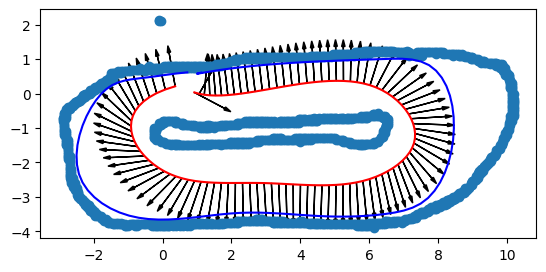

In [75]:
#try spline derivative
draw_normals(t3, tl, len(unew), unew)
draw_normals(t3, tr, )


In [30]:
right_points = [(new_points_left[0][i], new_points_left[1][i]) for i in range(len(new_points_left[0]))]
left_points = [(new_points_right[0][i], new_points_right[1][i]) for i in range(len(new_points_right[0]))]
cid = 0
pairs = []
ctree = cKDTree(left_points)
p = right_points.pop(0)
dis, ind =  ctree.query(p, 1)
pairs.append((p, left_points[ind]))
taken = [ind]
for i in right_points:
  if len(left_points)-2 > ind:
    if ind+1 in taken:
      ind -= 1
    elif ind-1 in taken:
      ind += 1
    else:
      dist1 = dist(i, left_points[ind + 1])
      dist2 = dist(i, left_points[ind - 1])
      if dist1 <= dist2: ind += 1
      else: ind -= 1
    pairs.append((i, left_points[ind]))
    taken.append(ind)
  elif len(pairs) != len(left_points):
    ind = 1

after pairing


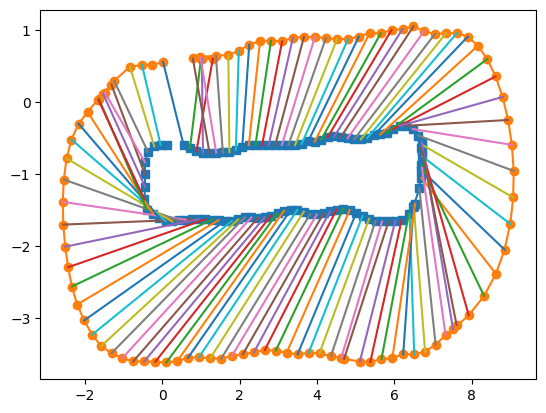

In [31]:
print("after pairing")
plt.plot(new_points_right[0], new_points_right[1], marker='s')
plt.plot(new_points_left[0], new_points_left[1], marker='o')

for i in pairs:
  plt.plot((i[0][0],i[1][0]), (i[0][1], i[1][1]))


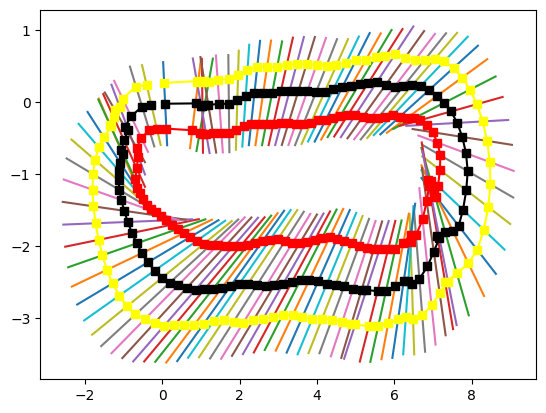

In [19]:
midsx = []
midsy = []
midsx2 = []
midsy2 = []
midsx3 = []
midsy3 = []
wt, wt1, wt2 = 0.5, 0.8, 0.25
for i in pairs:
  plt.plot((i[0][0],i[1][0]), (i[0][1], i[1][1]))
  midsx.append((wt*i[0][0] + (1-wt)*i[1][0]))
  midsy.append((wt*i[0][1] + (1-wt)*i[1][1]))
  midsx2.append((wt1*i[0][0] + (1-wt1)*i[1][0]))
  midsy2.append((wt1*i[0][1] + (1-wt1)*i[1][1]))
  midsx3.append((wt2*i[0][0] + (1-wt2)*i[1][0]))
  midsy3.append((wt2*i[0][1] + (1-wt2)*i[1][1]))
  

plt.plot(midsx, midsy, color = "black", marker='s')
plt.plot(midsx2, midsy2, color = "red", marker='s')
plt.plot(midsx3, midsy3, color = "yellow", marker='s')